In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2384972026018850958
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1815427173189116998
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time

start = time.time()

## Load data

In [5]:
directory = "Testing_data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

Loaded file: acp_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: dnp_d.csv
Loaded file: kgh_d.csv
Loaded file: pkn_d.csv


In [6]:
def get_moving_average(data, period):
    data['MA'] = data['Close'].rolling(period).mean()
    return data

In [7]:
def get_RSI (data, period):
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

In [8]:
def get_ROC(data):
    data['ROC'] = data['Close'].pct_change()
    return data

In [9]:
def get_stochastic_oscillator(data, period):
    L14, H14 = data['Close'].rolling(period).min(), data['Close'].rolling(period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)
    return data

In [10]:
def get_SO_moving_average(data, so_period, ma_period):
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    K = (data['Close'] - L14)/(H14 - L14)
    data['D'] = K.rolling(ma_period).mean()
    return data

In [11]:
def get_MACD(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    data['MACD'] = EMA_short - EMA_long
    return data

In [12]:
def get_MACD_histogram(data, period_long, period_short, period_signal):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    MACD = EMA_short - EMA_long
    MACD_signal = MACD.ewm(9).mean()
    data['MACD_Histogram'] = MACD - MACD_signal
    return data

In [13]:
def get_TEMA(data, period):
    SEMA = data['Close'].ewm(period).mean()
    DEMA = SEMA.ewm(period).mean()
    data['TEMA'] = DEMA.ewm(period).mean()
    return(data)

In [14]:
def get_CGI(data, period):
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)
    return(data)

In [15]:
def get_Williams_Percent_Range(data, period):
    data['Percent_Range'] = (data['Highest'].rolling(period).max() - data['Close']) / (data['Highest'].rolling(period).max() - data['Lowest'].rolling(period).min())
    return(data)

In [16]:
def scale_data(data):
    list_of_features = []
    for column in data.columns:
        list_of_features.append(data[column])

    dataset = np.transpose(list_of_features)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    return scaled_data, scaler

In [17]:
def scale_data_X_Y(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [18]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

# Testing for the best technical indicators parameters

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Checking how algorithm works without techincal indicators (learning based on prices and volume)

In [20]:
X_all = []
Y_all = []
stocks_base = []
results_base = []
# prepare data
for stock in stock_data_list:
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks_base.append(scaled_stock)
# split for training and validation
for stock in stocks_base:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_base.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_base = pd.DataFrame(results_base)

(27145, 60, 5)
(3017, 60, 5)
(27145, 5)
(3017, 5)
Epoch 1/7
849/849 [==============================] - 8s 5ms/step - loss: 0.0070 - val_loss: 8.4569e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.9296e-04 - val_loss: 7.4700e-04
Epoch 3/7
849/849 [==============================] - 3s 4ms/step - loss: 4.9859e-04 - val_loss: 6.3698e-04
Epoch 4/7
849/849 [==============================] - 3s 4ms/step - loss: 4.8893e-04 - val_loss: 6.1500e-04
Epoch 5/7
849/849 [==============================] - 3s 4ms/step - loss: 4.6151e-04 - val_loss: 5.9128e-04
Epoch 6/7
849/849 [==============================] - 3s 4ms/step - loss: 4.3273e-04 - val_loss: 6.1227e-04
Epoch 7/7
849/849 [==============================] - 3s 4ms/step - loss: 4.3216e-04 - val_loss: 6.0175e-04
Epoch 1/7
849/849 [==============================] - 5s 4ms/step - loss: 0.0068 - val_loss: 7.6357e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.0886e-04 - val_loss: 8.6420

In [21]:
results_base

,loss,val_loss
0,0.000435,0.000593


### Moving average

In [22]:
periods = [3, 5, 10, 15, 20, 30, 45, 60, 80, 100, 125, 150, 200]
X_all_MA = []
Y_all_MA = []
results_MA = []


for period in periods:
    X_all_MA = []
    Y_all_MA = []
    stocks_MA = []
    # prepare data
    for stock in stock_data_list:
        stock_MA = get_moving_average(stock, period)
        stock_MA = stock_MA.dropna()
        scaled_stock, stock_scaler = scale_data(stock_MA.drop(columns='Date'))
        stocks_MA.append(scaled_stock)
    # split for training and validation
    for stock_MA in stocks_MA:
        X, Y = prepare_input_and_output(np.array(stock_MA))
        X_all_MA = X_all_MA + X
        Y_all_MA = Y_all_MA + Y
    X_all_MA, Y_all_MA = np.array(X_all_MA), np.array(Y_all_MA)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all_MA, Y_all_MA, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MA = pd.DataFrame(results_MA)


(27133, 60, 6)
(3015, 60, 6)
(27133, 5)
(3015, 5)
Period: 3
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0272 - val_loss: 8.2918e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.6606e-04 - val_loss: 7.1744e-04
Epoch 3/7
848/848 [==============================] - 3s 4ms/step - loss: 4.8490e-04 - val_loss: 6.8556e-04
Epoch 4/7
848/848 [==============================] - 3s 4ms/step - loss: 4.6937e-04 - val_loss: 6.9911e-04
Epoch 5/7
848/848 [==============================] - 3s 4ms/step - loss: 4.8522e-04 - val_loss: 6.9623e-04
Epoch 6/7
848/848 [==============================] - 3s 4ms/step - loss: 4.5451e-04 - val_loss: 8.0747e-04
Epoch 7/7
848/848 [==============================] - 3s 4ms/step - loss: 4.4886e-04 - val_loss: 6.6887e-04
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0121 - val_loss: 7.9261e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.3098e-04 - val_lo

Epoch 6/7
846/846 [==============================] - 3s 4ms/step - loss: 4.8502e-04 - val_loss: 6.5755e-04
Epoch 7/7
846/846 [==============================] - 3s 4ms/step - loss: 4.4811e-04 - val_loss: 8.3117e-04
Epoch 1/7
846/846 [==============================] - 5s 5ms/step - loss: 0.0061 - val_loss: 7.7236e-04
Epoch 2/7
846/846 [==============================] - 3s 4ms/step - loss: 5.2592e-04 - val_loss: 7.7802e-04
Epoch 3/7
846/846 [==============================] - 3s 4ms/step - loss: 4.8926e-04 - val_loss: 7.4276e-04
Epoch 4/7
846/846 [==============================] - 3s 4ms/step - loss: 4.8170e-04 - val_loss: 6.4841e-04
Epoch 5/7
846/846 [==============================] - 3s 4ms/step - loss: 4.6862e-04 - val_loss: 7.1879e-04
Epoch 6/7
846/846 [==============================] - 3s 4ms/step - loss: 4.3276e-04 - val_loss: 7.0434e-04
Epoch 7/7
846/846 [==============================] - 3s 4ms/step - loss: 4.2593e-04 - val_loss: 6.3576e-04
(27026, 60, 6)
(3003, 60, 6)
(27026, 5)
(

837/837 [==============================] - 3s 4ms/step - loss: 5.9439e-04 - val_loss: 7.1664e-04
Epoch 4/7
837/837 [==============================] - 3s 4ms/step - loss: 4.8562e-04 - val_loss: 6.9746e-04
Epoch 5/7
837/837 [==============================] - 3s 4ms/step - loss: 5.1892e-04 - val_loss: 6.7660e-04
Epoch 6/7
837/837 [==============================] - 3s 4ms/step - loss: 4.4495e-04 - val_loss: 6.7280e-04
Epoch 7/7
837/837 [==============================] - 3s 4ms/step - loss: 4.6948e-04 - val_loss: 6.5727e-04
Epoch 1/7
837/837 [==============================] - 5s 4ms/step - loss: 0.0198 - val_loss: 0.0011
Epoch 2/7
837/837 [==============================] - 3s 4ms/step - loss: 5.6349e-04 - val_loss: 7.6354e-04
Epoch 3/7
837/837 [==============================] - 3s 4ms/step - loss: 5.0822e-04 - val_loss: 6.9408e-04
Epoch 4/7
837/837 [==============================] - 3s 4ms/step - loss: 4.6480e-04 - val_loss: 6.5076e-04
Epoch 5/7
837/837 [==============================] - 3s

824/824 [==============================] - 5s 4ms/step - loss: 0.0119 - val_loss: 7.3846e-04
Epoch 2/7
824/824 [==============================] - 3s 4ms/step - loss: 5.5931e-04 - val_loss: 7.9977e-04
Epoch 3/7
824/824 [==============================] - 3s 4ms/step - loss: 4.8305e-04 - val_loss: 6.6295e-04
Epoch 4/7
824/824 [==============================] - 3s 4ms/step - loss: 5.1267e-04 - val_loss: 6.4799e-04
Epoch 5/7
824/824 [==============================] - 3s 4ms/step - loss: 4.3746e-04 - val_loss: 6.5275e-04
Epoch 6/7
824/824 [==============================] - 3s 4ms/step - loss: 4.5879e-04 - val_loss: 6.1961e-04
Epoch 7/7
824/824 [==============================] - 3s 4ms/step - loss: 4.5914e-04 - val_loss: 6.3273e-04
(26207, 60, 6)
(2912, 60, 6)
(26207, 5)
(2912, 5)
Period: 150
Epoch 1/7
819/819 [==============================] - 5s 4ms/step - loss: 0.0135 - val_loss: 0.0012
Epoch 2/7
819/819 [==============================] - 3s 4ms/step - loss: 8.5528e-04 - val_loss: 9.0434e-

In [23]:
results_MA

,period,loss,val_loss
0,3,0.000447,0.000710
1,5,0.000457,0.000648
2,10,0.000451,0.000673
3,15,0.000448,0.000711
4,20,0.000450,0.000713
5,30,0.000453,0.000649
6,45,0.000457,0.000664
7,60,0.000460,0.000679
8,80,0.000457,0.000623
9,100,0.000453,0.000667


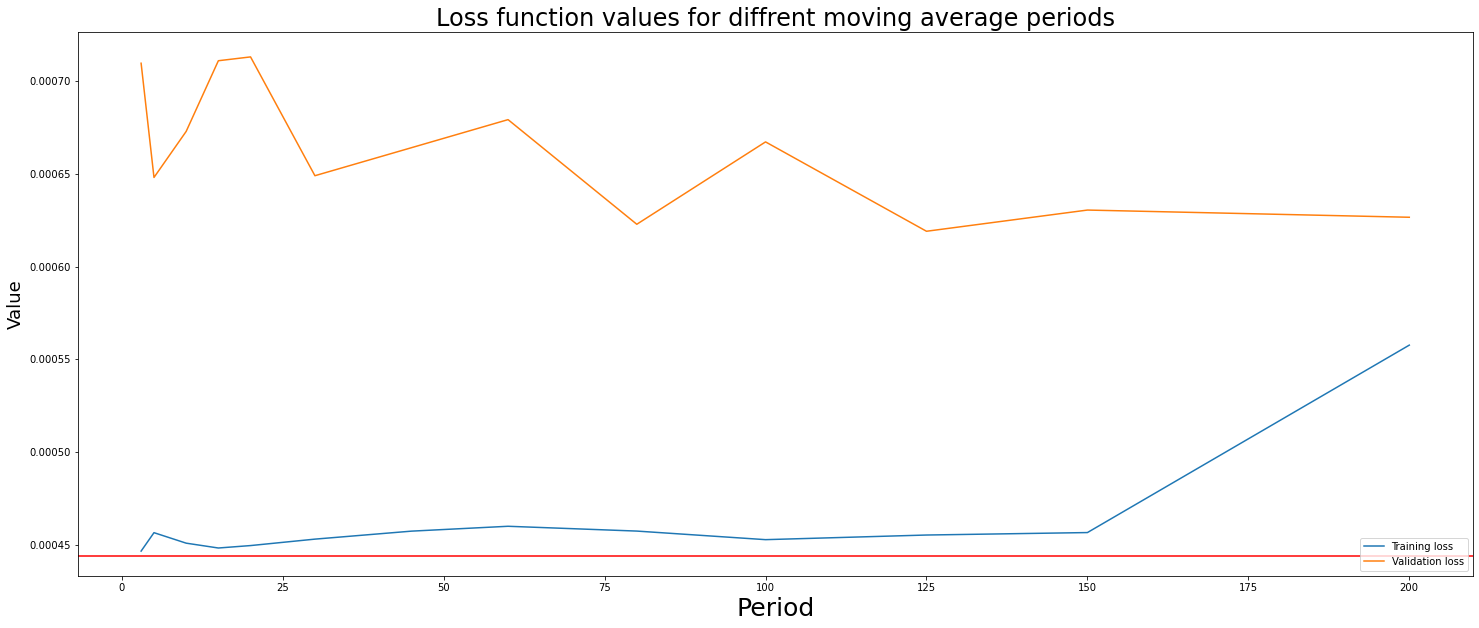

In [24]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MA['period'], results_MA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

### RSI

In [25]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_RSI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_RSI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_RSI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_RSI = pd.DataFrame(results_RSI)


(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0156 - val_loss: 6.8968e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3201e-04 - val_loss: 6.3764e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7541e-04 - val_loss: 6.4113e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7870e-04 - val_loss: 6.3558e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3653e-04 - val_loss: 6.5289e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6989e-04 - val_loss: 6.1684e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.1847e-04 - val_loss: 6.0460e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0114 - val_loss: 6.6872e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5402e-04 - val_lo

810/810 [==============================] - 3s 4ms/step - loss: 6.1547e-04 - val_loss: 6.0833e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3874e-04 - val_loss: 6.6249e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7274e-04 - val_loss: 6.0192e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0163 - val_loss: 7.6464e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 7.1245e-04 - val_loss: 7.5907e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3354e-04 - val_loss: 6.7903e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2328e-04 - val_loss: 6.3486e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8062e-04 - val_loss: 6.4177e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4702e-04 - val_loss: 6.2261e-04
Epoch 7/7
810/810 [==============================] 

In [26]:
results_RSI

,period,loss,val_loss
0,3,0.000556,0.000619
1,5,0.000555,0.000643
2,7,0.000554,0.000684
3,10,0.000556,0.000612
4,14,0.000552,0.000627


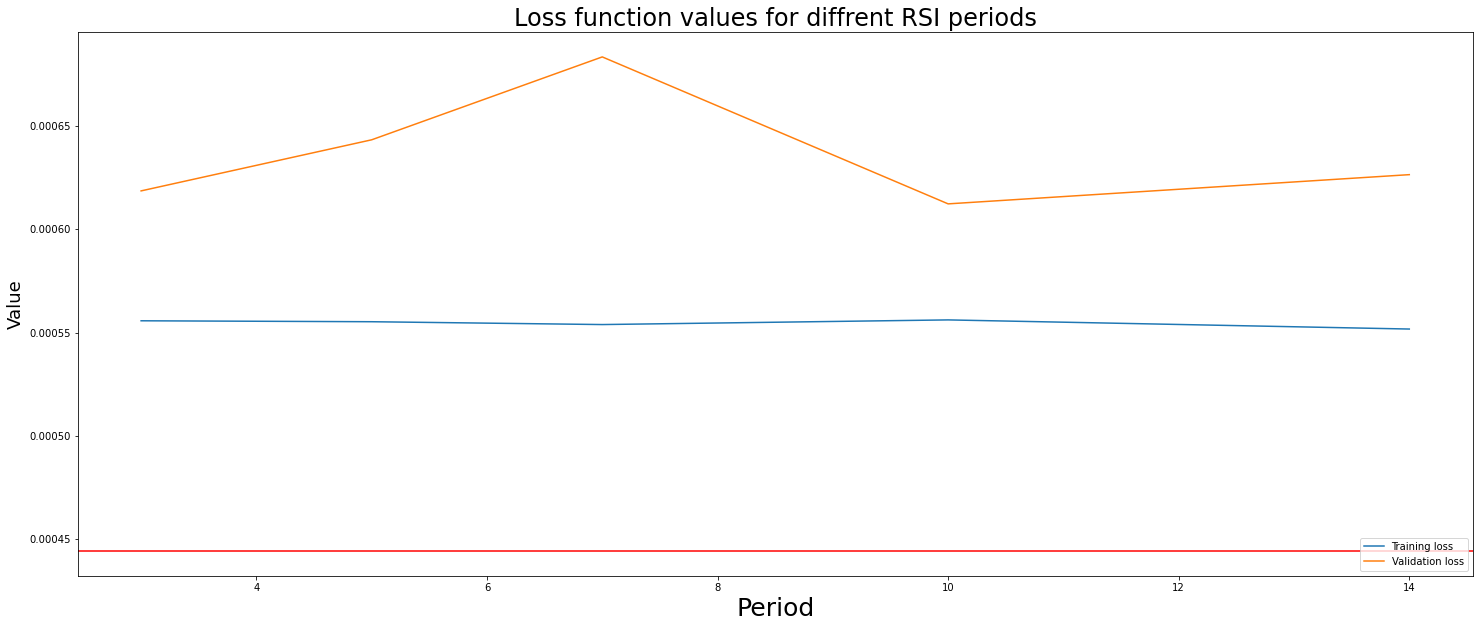

In [27]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent RSI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_RSI['period'], results_RSI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## ROC

In [28]:
X_all = []
Y_all = []
results_ROC = []


X_all = []
Y_all = []
stocks = []
# prepare data
for stock in stock_data_list:
    stock = get_ROC(stock)
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks.append(scaled_stock)
# split for training and validation
for stock in stocks:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_ROC.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_ROC = pd.DataFrame(results_ROC)

(25892, 60, 8)
(2877, 60, 8)
(25892, 5)
(2877, 5)
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0104 - val_loss: 7.5543e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1483e-04 - val_loss: 6.2990e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7079e-04 - val_loss: 6.3240e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8478e-04 - val_loss: 6.4673e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3301e-04 - val_loss: 8.4835e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6631e-04 - val_loss: 6.1304e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5077e-04 - val_loss: 6.1522e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0091 - val_loss: 7.2018e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2403e-04 - val_loss: 6.5156

In [29]:
results_ROC

,loss,val_loss
0,0.000547,0.000616


## Stochastic oscillator

In [30]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_SO = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_stochastic_oscillator(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_SO.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO = pd.DataFrame(results_SO)


(25738, 60, 9)
(2860, 60, 9)
(25738, 5)
(2860, 5)
Period: 3
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0056 - val_loss: 7.4630e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.3946e-04 - val_loss: 6.5524e-04
Epoch 3/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9175e-04 - val_loss: 7.0331e-04
Epoch 4/7
805/805 [==============================] - 3s 4ms/step - loss: 5.6468e-04 - val_loss: 6.3477e-04
Epoch 5/7
805/805 [==============================] - 3s 4ms/step - loss: 5.6110e-04 - val_loss: 6.2815e-04
Epoch 6/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9809e-04 - val_loss: 6.2549e-04
Epoch 7/7
805/805 [==============================] - 3s 4ms/step - loss: 5.2032e-04 - val_loss: 8.0499e-04
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0048 - val_loss: 6.7499e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.4302e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5895e-04 - val_loss: 6.1064e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4519e-04 - val_loss: 7.4896e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0117 - val_loss: 6.8684e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3895e-04 - val_loss: 6.4386e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0215e-04 - val_loss: 6.1348e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7797e-04 - val_loss: 6.2820e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8365e-04 - val_loss: 6.1770e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4022e-04 - val_loss: 6.2002e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6312e-04 - val_loss: 6.7909e-04
(25892, 60, 9)
(2877, 60, 9)
(25892, 5)
(

In [31]:
results_SO

,period,loss,val_loss
0,3,0.000556,0.000691
1,5,0.000549,0.000631
2,7,0.000553,0.000599
3,10,0.000554,0.000706
4,14,0.000547,0.000624


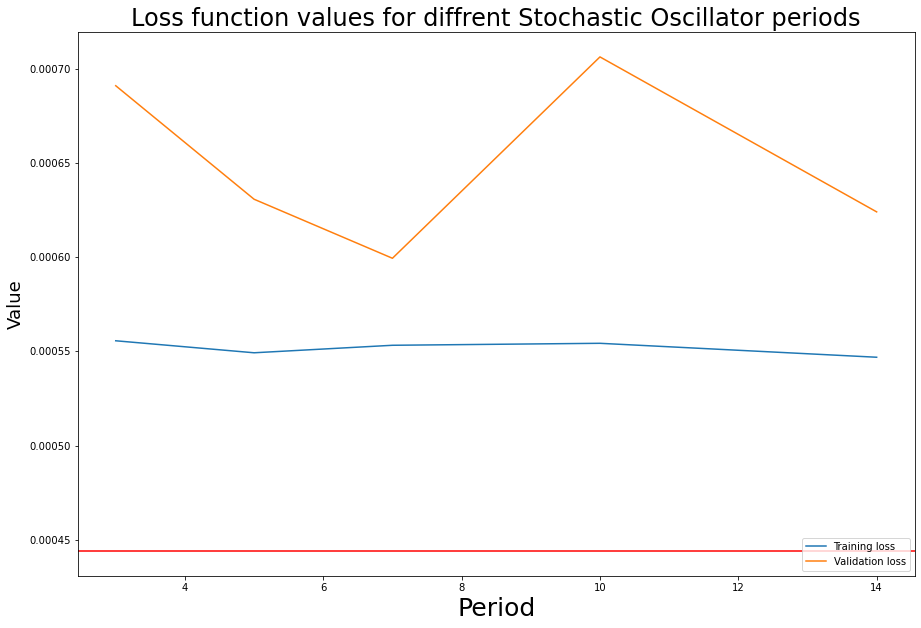

In [32]:
plt.figure(figsize=(15,10))
plt.title('Loss function values for diffrent Stochastic Oscillator periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_SO['period'], results_SO[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [33]:
so_periods = [3, 5, 7, 10, 14]
ma_periods = [2, 3, 4, 5, 6]
X_all = []
Y_all = []
results_SO_MA = []


for so_period in so_periods:
    for ma_period in ma_periods:
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_SO_moving_average(stock, so_period, ma_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Stochastic Oscillator period: ' + str(so_period))
        print('Moving average period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_SO_MA.append({'so_period': so_period, 'ma_period': ma_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO_MA = pd.DataFrame(results_SO_MA)


(25615, 60, 10)
(2847, 60, 10)
(25615, 5)
(2847, 5)
Stochastic Oscillator period: 3
Moving average period: 2
Epoch 1/7
801/801 [==============================] - 5s 4ms/step - loss: 0.0147 - val_loss: 7.6846e-04
Epoch 2/7
801/801 [==============================] - 3s 4ms/step - loss: 6.9097e-04 - val_loss: 6.6926e-04
Epoch 3/7
801/801 [==============================] - 3s 4ms/step - loss: 5.9695e-04 - val_loss: 6.8713e-04
Epoch 4/7
801/801 [==============================] - 3s 4ms/step - loss: 6.0242e-04 - val_loss: 6.7880e-04
Epoch 5/7
801/801 [==============================] - 3s 4ms/step - loss: 6.2196e-04 - val_loss: 6.5809e-04
Epoch 6/7
801/801 [==============================] - 3s 4ms/step - loss: 5.3705e-04 - val_loss: 6.3217e-04
Epoch 7/7
801/801 [==============================] - 3s 4ms/step - loss: 5.6742e-04 - val_loss: 6.1085e-04
Epoch 1/7
801/801 [==============================] - 5s 4ms/step - loss: 0.0083 - val_loss: 7.5690e-04
Epoch 2/7
801/801 [========================

Epoch 4/7
790/790 [==============================] - 5s 6ms/step - loss: 5.7399e-04 - val_loss: 6.7460e-04
Epoch 5/7
790/790 [==============================] - 5s 6ms/step - loss: 5.7727e-04 - val_loss: 6.4668e-04
Epoch 6/7
790/790 [==============================] - 5s 6ms/step - loss: 5.6244e-04 - val_loss: 6.4102e-04
Epoch 7/7
790/790 [==============================] - 5s 6ms/step - loss: 5.6392e-04 - val_loss: 6.6353e-04
Epoch 1/7
790/790 [==============================] - 8s 7ms/step - loss: 0.0059 - val_loss: 7.2034e-04
Epoch 2/7
790/790 [==============================] - 5s 6ms/step - loss: 6.8049e-04 - val_loss: 6.3156e-04
Epoch 3/7
790/790 [==============================] - 5s 6ms/step - loss: 6.2524e-04 - val_loss: 7.0763e-04
Epoch 4/7
790/790 [==============================] - 5s 6ms/step - loss: 5.9924e-04 - val_loss: 6.4500e-04
Epoch 5/7
790/790 [==============================] - 5s 6ms/step - loss: 6.0648e-04 - val_loss: 6.2139e-04
Epoch 6/7
790/790 [======================

(25866, 60, 10)
(2874, 60, 10)
(25866, 5)
(2874, 5)
Stochastic Oscillator period: 5
Moving average period: 4
Epoch 1/7
809/809 [==============================] - 8s 6ms/step - loss: 0.0065 - val_loss: 7.6603e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.5460e-04 - val_loss: 7.0116e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.0323e-04 - val_loss: 6.9106e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.6257e-04 - val_loss: 6.6920e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5148e-04 - val_loss: 6.4177e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7279e-04 - val_loss: 6.2532e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7731e-04 - val_loss: 6.1957e-04
Epoch 1/7
809/809 [==============================] - 8s 7ms/step - loss: 0.0133 - val_loss: 9.7918e-04
Epoch 2/7
809/809 [========================

809/809 [==============================] - 4s 5ms/step - loss: 5.4938e-04 - val_loss: 6.3555e-04
Epoch 5/7
809/809 [==============================] - 4s 5ms/step - loss: 5.3274e-04 - val_loss: 6.1682e-04
Epoch 6/7
809/809 [==============================] - 4s 5ms/step - loss: 6.1121e-04 - val_loss: 6.3684e-04
Epoch 7/7
809/809 [==============================] - 4s 5ms/step - loss: 5.7592e-04 - val_loss: 6.1716e-04
Epoch 1/7
809/809 [==============================] - 8s 6ms/step - loss: 0.0039 - val_loss: 7.8530e-04
Epoch 2/7
809/809 [==============================] - 4s 5ms/step - loss: 5.9407e-04 - val_loss: 6.4048e-04
Epoch 3/7
809/809 [==============================] - 4s 5ms/step - loss: 5.8397e-04 - val_loss: 7.6404e-04
Epoch 4/7
809/809 [==============================] - 4s 5ms/step - loss: 5.6988e-04 - val_loss: 6.8081e-04
Epoch 5/7
809/809 [==============================] - 4s 5ms/step - loss: 5.8497e-04 - val_loss: 6.0558e-04
Epoch 6/7
809/809 [==============================] 

Epoch 1/7
809/809 [==============================] - 8s 6ms/step - loss: 0.0207 - val_loss: 7.5921e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.4455e-04 - val_loss: 6.9096e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.2897e-04 - val_loss: 6.7438e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7532e-04 - val_loss: 7.0343e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7340e-04 - val_loss: 6.2934e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5878e-04 - val_loss: 6.3669e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.2809e-04 - val_loss: 6.0517e-04
Epoch 1/7
809/809 [==============================] - 8s 7ms/step - loss: 0.0104 - val_loss: 7.2414e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.4708e-04 - val_loss: 6.9486e-04
Epoch 3/7
809/809 [==========================

Epoch 5/7
810/810 [==============================] - 4s 6ms/step - loss: 5.8563e-04 - val_loss: 6.4773e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4534e-04 - val_loss: 6.9142e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.1488e-04 - val_loss: 7.0250e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0042 - val_loss: 8.5084e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.4730e-04 - val_loss: 6.3846e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9238e-04 - val_loss: 6.9467e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7436e-04 - val_loss: 6.3413e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 6.0715e-04 - val_loss: 6.2271e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.2816e-04 - val_loss: 6.0245e-04
Epoch 7/7
810/810 [======================

Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0113 - val_loss: 7.3364e-04
Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 6.4940e-04 - val_loss: 6.9898e-04
Epoch 3/7
810/810 [==============================] - 4s 6ms/step - loss: 5.8437e-04 - val_loss: 6.2252e-04
Epoch 4/7
810/810 [==============================] - 4s 6ms/step - loss: 5.6537e-04 - val_loss: 6.2409e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6881e-04 - val_loss: 6.5520e-04
Epoch 6/7
810/810 [==============================] - 4s 6ms/step - loss: 5.4744e-04 - val_loss: 6.8269e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.5297e-04 - val_loss: 6.0048e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0132 - val_loss: 9.2467e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 9.5806e-04 - val_loss: 8.3269e-04
Epoch 3/7
810/810 [==========================

Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9304e-04 - val_loss: 6.3694e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.5909e-04 - val_loss: 6.0767e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4133e-04 - val_loss: 6.6901e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0187 - val_loss: 8.4720e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 7.2257e-04 - val_loss: 6.7032e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.3966e-04 - val_loss: 7.1319e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 6.0568e-04 - val_loss: 7.2652e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.2769e-04 - val_loss: 6.9773e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4968e-04 - val_loss: 7.0754e-04
Epoch 7/7
810/810 [======================

In [34]:
results_SO_MA

,so_period,ma_period,loss,val_loss
0,3,2,0.000555,0.000618
1,3,3,0.000559,0.000614
2,3,4,0.000559,0.000612
3,3,5,0.000565,0.000658
4,3,6,0.000563,0.000632
5,5,2,0.000549,0.000608
6,5,3,0.000556,0.000635
7,5,4,0.000552,0.000615
8,5,5,0.000550,0.000636
9,5,6,0.000555,0.000610


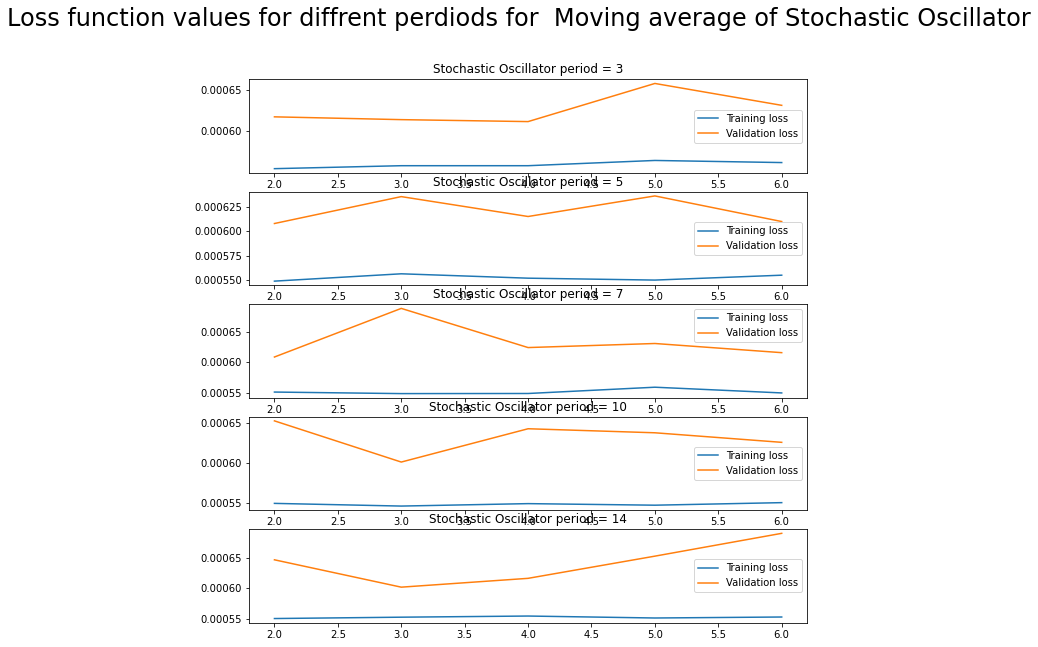

In [35]:
fig, axes = plt.subplots(len(results_SO_MA['so_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for so_period in results_SO_MA['so_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(so_period))
    axes[axes_counter].plot(results_SO_MA['ma_period'].where(results_SO_MA['so_period']==so_period), results_SO_MA[['loss', 'val_loss']].where(results_SO_MA['so_period']==so_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

In [36]:
long_periods = [10, 18, 26]
short_periods = [6, 9, 12]
X_all = []
Y_all = []
results_MACD = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_MACD(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_MACD.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD = pd.DataFrame(results_MACD)


(25892, 60, 11)
(2877, 60, 11)
(25892, 5)
(2877, 5)
Long period: 14
Short period: 6
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0339 - val_loss: 0.0011
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 0.0010 - val_loss: 6.4252e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.1721e-04 - val_loss: 7.2923e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7416e-04 - val_loss: 7.1831e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7694e-04 - val_loss: 6.4647e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8311e-04 - val_loss: 6.4223e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.5408e-04 - val_loss: 6.2298e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0156 - val_loss: 9.2556e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 7.2

Epoch 5/7
810/810 [==============================] - 4s 6ms/step - loss: 5.7414e-04 - val_loss: 6.6513e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8925e-04 - val_loss: 6.1994e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6136e-04 - val_loss: 6.5544e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0098 - val_loss: 9.1063e-04
Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 7.3669e-04 - val_loss: 7.2135e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.1048e-04 - val_loss: 7.6051e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9128e-04 - val_loss: 7.8147e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9629e-04 - val_loss: 8.0949e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9060e-04 - val_loss: 6.4396e-04
Epoch 7/7
810/810 [======================

Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 6.6835e-04 - val_loss: 6.9193e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.1453e-04 - val_loss: 8.0296e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 6.0623e-04 - val_loss: 7.5132e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.5943e-04 - val_loss: 6.6808e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4554e-04 - val_loss: 6.3385e-04
Epoch 7/7
810/810 [==============================] - 4s 6ms/step - loss: 5.6120e-04 - val_loss: 6.5396e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0172 - val_loss: 6.9877e-04
Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 6.1686e-04 - val_loss: 6.3186e-04
Epoch 3/7
810/810 [==============================] - 4s 6ms/step - loss: 5.8700e-04 - val_loss: 6.1310e-04
Epoch 4/7
810/810 [======================

In [37]:
results_MACD

,long_period,short_period,loss,val_loss
0,10,6,0.000549,0.000631
1,10,9,0.000553,0.000619
2,18,6,0.000553,0.000670
3,18,9,0.000559,0.000702
4,18,12,0.000555,0.000675
5,26,6,0.000556,0.000616
6,26,9,0.000555,0.000624
7,26,12,0.000553,0.000648


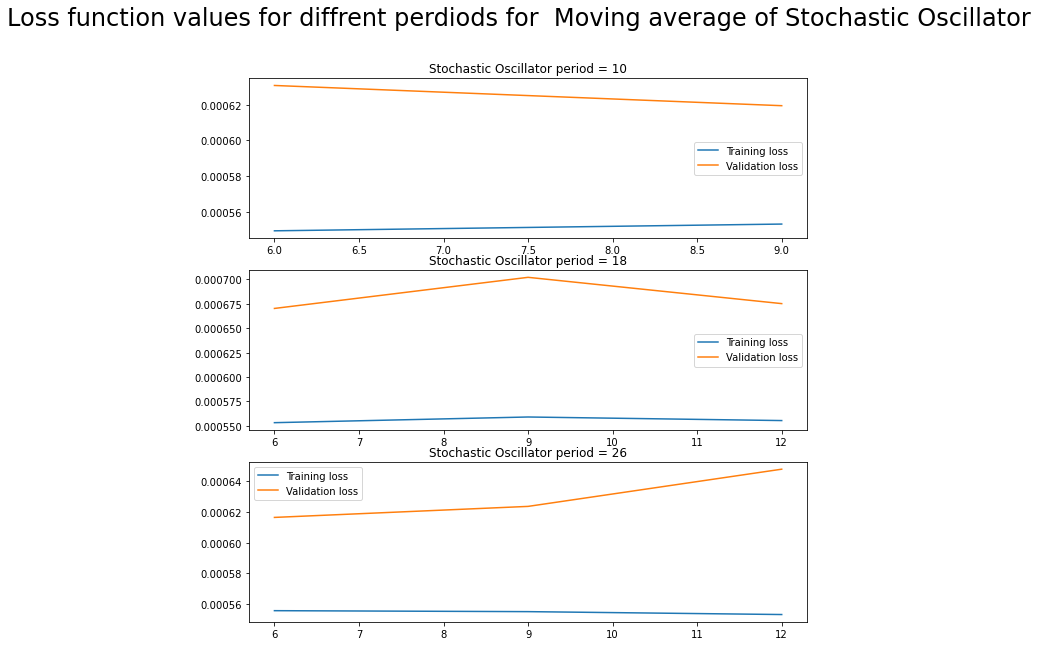

In [38]:
fig, axes = plt.subplots(len(results_MACD['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for long_period in results_MACD['long_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(long_period))
    axes[axes_counter].plot(results_MACD['short_period'].where(results_MACD['long_period']==long_period), results_MACD[['loss', 'val_loss']].where(results_MACD['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

In [39]:
long_period = 26
short_period = 12
signal_periods = [3, 5, 9, 12]

X_all = []
Y_all = []
results_MACD_histogram = []


for signal_period in signal_periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_MACD_histogram(stock, long_period, short_period, signal_period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Signal line period: ' + str(signal_period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MACD_histogram.append({'long_period': long_period,'short_period': short_period,'signal_period': signal_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD_histogram = pd.DataFrame(results_MACD_histogram)


(25892, 60, 12)
(2877, 60, 12)
(25892, 5)
(2877, 5)
Signal line period: 3
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0146 - val_loss: 7.7121e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.8347e-04 - val_loss: 6.7647e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.2549e-04 - val_loss: 6.7331e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8892e-04 - val_loss: 6.3866e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6305e-04 - val_loss: 6.2258e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9009e-04 - val_loss: 6.3898e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.3755e-04 - val_loss: 6.2925e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0133 - val_loss: 8.9197e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.820

810/810 [==============================] - 5s 6ms/step - loss: 5.5993e-04 - val_loss: 6.1513e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.3938e-04 - val_loss: 6.8841e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7057e-04 - val_loss: 6.7162e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0075 - val_loss: 7.0523e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.6322e-04 - val_loss: 6.5010e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6122e-04 - val_loss: 6.6691e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 6.3830e-04 - val_loss: 6.6248e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9720e-04 - val_loss: 6.6450e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 6.0265e-04 - val_loss: 5.9988e-04
Epoch 7/7
810/810 [==============================] 

In [40]:
results_MACD_histogram

,long_period,short_period,signal_period,loss,val_loss
0,26,12,3,0.000556,0.000632
1,26,12,5,0.000551,0.000657
2,26,12,9,0.000556,0.000648
3,26,12,12,0.000556,0.000643


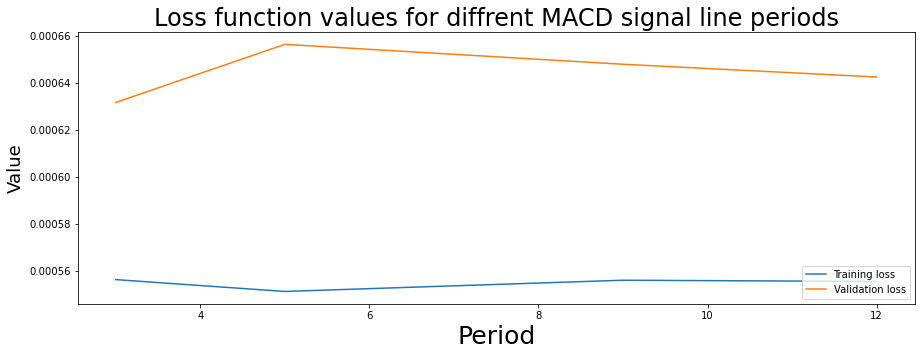

In [41]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent MACD signal line periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MACD_histogram['signal_period'], results_MACD_histogram[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

## Triple exponential moving average TEMA

In [42]:
periods = [3, 5, 9, 12, 15, 21]

X_all = []
Y_all = []
results_TEMA = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_TEMA(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('TEMA period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_TEMA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_TEMA = pd.DataFrame(results_TEMA)


(25892, 60, 13)
(2877, 60, 13)
(25892, 5)
(2877, 5)
TEMA period: 3
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0136 - val_loss: 8.3320e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 7.1090e-04 - val_loss: 6.7097e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.5562e-04 - val_loss: 6.5459e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.3330e-04 - val_loss: 5.9861e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 6.0281e-04 - val_loss: 6.5310e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 6.4080e-04 - val_loss: 6.0583e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.2373e-04 - val_loss: 6.0638e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0130 - val_loss: 7.8202e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.9618e-04 -

810/810 [==============================] - 5s 6ms/step - loss: 5.4751e-04 - val_loss: 6.2989e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6001e-04 - val_loss: 6.0213e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7547e-04 - val_loss: 6.4249e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0092 - val_loss: 8.8573e-04
Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 7.6034e-04 - val_loss: 7.1578e-04
Epoch 3/7
810/810 [==============================] - 4s 6ms/step - loss: 6.4086e-04 - val_loss: 6.5706e-04
Epoch 4/7
810/810 [==============================] - 4s 6ms/step - loss: 6.2589e-04 - val_loss: 6.2328e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9778e-04 - val_loss: 6.3605e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8031e-04 - val_loss: 6.2218e-04
Epoch 7/7
810/810 [==============================] 

In [43]:
results_TEMA

,period,loss,val_loss
0,3,0.000556,0.000614
1,5,0.000553,0.000679
2,9,0.000551,0.000626
3,12,0.000550,0.000626
4,15,0.000552,0.000875
5,21,0.000562,0.000634


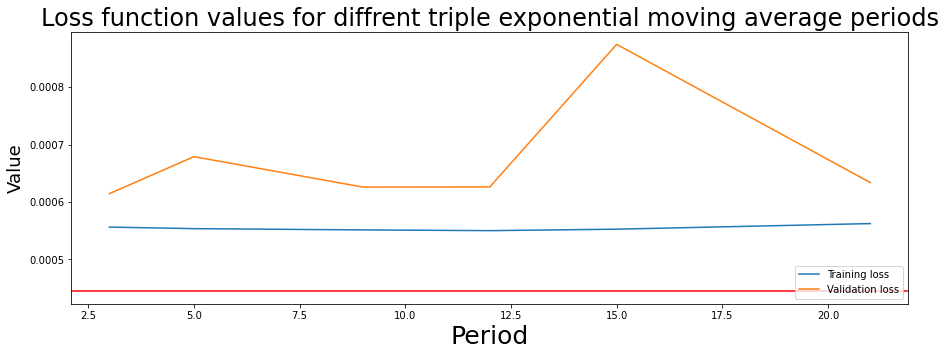

In [44]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent triple exponential moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_TEMA['period'], results_TEMA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Commodity Channel  Index CGI

In [45]:
periods = [5, 10, 15, 20]

X_all = []
Y_all = []
results_CGI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_CGI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('CGI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_CGI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_CGI = pd.DataFrame(results_CGI)


(25892, 60, 14)
(2877, 60, 14)
(25892, 5)
(2877, 5)
CGI period: 5
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0131 - val_loss: 7.4547e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.5367e-04 - val_loss: 6.8283e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6801e-04 - val_loss: 6.6309e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7695e-04 - val_loss: 6.3968e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8900e-04 - val_loss: 6.6075e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.9555e-04 - val_loss: 6.6742e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8709e-04 - val_loss: 7.9028e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0501 - val_loss: 0.0010
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 9.2908e-04 - val_

810/810 [==============================] - 5s 6ms/step - loss: 6.2266e-04 - val_loss: 6.1032e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.8437e-04 - val_loss: 7.5262e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6575e-04 - val_loss: 6.3641e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0229 - val_loss: 7.6671e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 9.1497e-04 - val_loss: 8.5976e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.8850e-04 - val_loss: 6.5169e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6492e-04 - val_loss: 6.7168e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4982e-04 - val_loss: 7.5945e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7489e-04 - val_loss: 6.1446e-04
Epoch 7/7
810/810 [==============================] 

In [46]:
results_CGI

,period,loss,val_loss
0,5,0.000552,0.000675
1,10,0.000551,0.000695
2,15,0.000556,0.000624
3,20,0.000561,0.000673


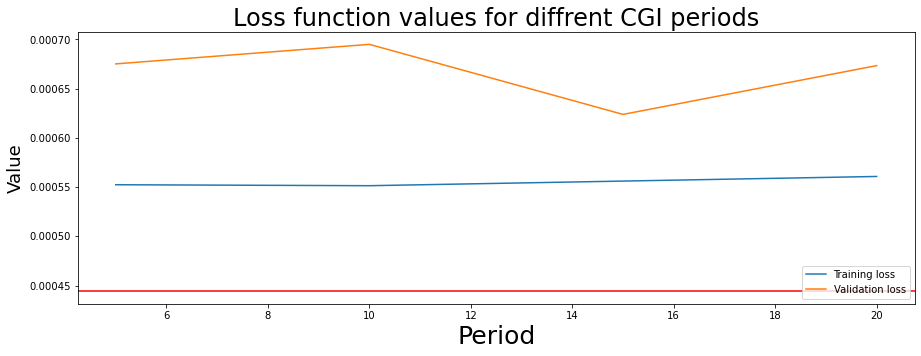

In [47]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent CGI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_CGI['period'], results_CGI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Williams Percent Range WPI

In [48]:
periods = [5, 7, 10, 14, 21]

X_all = []
Y_all = []
results_WPI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_Williams_Percent_Range(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('WPI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_WPI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_WPI = pd.DataFrame(results_WPI)


(25892, 60, 15)
(2877, 60, 15)
(25892, 5)
(2877, 5)
WPI period: 5
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0116 - val_loss: 9.2867e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 7.5559e-04 - val_loss: 8.4869e-04
Epoch 3/7
810/810 [==============================] - 4s 6ms/step - loss: 6.5277e-04 - val_loss: 6.5802e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7016e-04 - val_loss: 6.8261e-04
Epoch 5/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7296e-04 - val_loss: 6.2974e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.4743e-04 - val_loss: 6.2437e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.3894e-04 - val_loss: 6.7314e-04
Epoch 1/7
810/810 [==============================] - 8s 7ms/step - loss: 0.0080 - val_loss: 7.0098e-04
Epoch 2/7
810/810 [==============================] - 5s 6ms/step - loss: 6.6289e-04 - 

810/810 [==============================] - 5s 6ms/step - loss: 5.9939e-04 - val_loss: 5.9936e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.5182e-04 - val_loss: 6.9517e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms/step - loss: 5.6749e-04 - val_loss: 6.5893e-04
Epoch 1/7
810/810 [==============================] - 8s 6ms/step - loss: 0.0365 - val_loss: 0.0034
Epoch 2/7
810/810 [==============================] - 4s 6ms/step - loss: 0.0012 - val_loss: 7.0119e-04
Epoch 3/7
810/810 [==============================] - 5s 6ms/step - loss: 6.1769e-04 - val_loss: 6.1689e-04
Epoch 4/7
810/810 [==============================] - 5s 6ms/step - loss: 5.7352e-04 - val_loss: 6.4884e-04
Epoch 5/7
810/810 [==============================] - 4s 6ms/step - loss: 5.4909e-04 - val_loss: 5.9961e-04
Epoch 6/7
810/810 [==============================] - 5s 6ms/step - loss: 5.3683e-04 - val_loss: 6.6514e-04
Epoch 7/7
810/810 [==============================] - 5s 6ms

In [49]:
results_WPI

,period,loss,val_loss
0,5,0.000557,0.000647
1,7,0.000558,0.000650
2,10,0.000550,0.000655
3,14,0.000550,0.000643
4,21,0.000554,0.000673


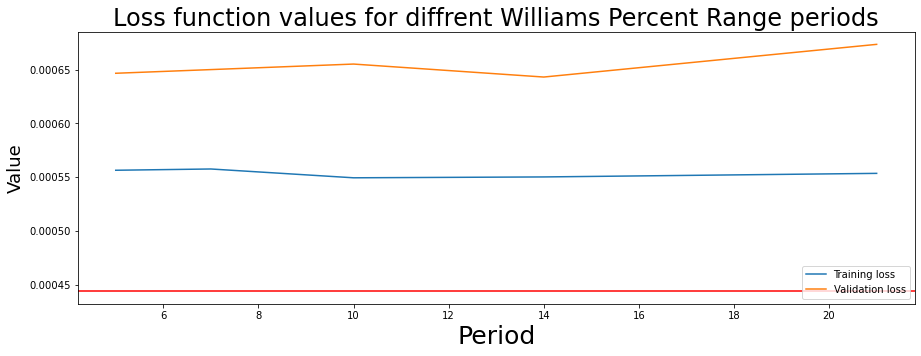

In [50]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent Williams Percent Range periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_WPI['period'], results_WPI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [51]:
end = time.time()
print('Time of executing the script: ' + str(round((end - start)/3600, 2)) + 'h')

Time of executing the script: 2.77h
